In [ ]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 27.9 MB/s 
     |████████████████████████████████| 7.6 MB 65.8 MB/s 
     |████████████████████████████████| 182 kB 97.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 35.9 MB/s 
     |████████████████████████████████| 132 kB 64.1 MB/s 
     |████████████████████████████████| 212 kB 101.1 MB/s 
     |████████████████████████████████| 127 kB 94.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer

import pandas as pd
import numpy as np
import random
import time
import datetime
from tqdm.notebook import tqdm

import csv
import os
from datasets import Dataset

In [ ]:
datasets = pd.read_csv('/content/drive/Shareddrives/SW2_0916/3ck/dataset/aihub_okt.csv', index_col=0)

In [ ]:
import ast
datasets.types = datasets.types.map(ast.literal_eval)
datasets.okt_text = datasets.okt_text.map(ast.literal_eval)

In [ ]:
from sklearn.model_selection import train_test_split
X = datasets.text
y = datasets.types
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(171514,) (171514,) (114344,) (114344,) (122511,) (122511,)


In [ ]:
train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
valid = pd.concat([X_valid, y_valid], axis=1).reset_index(drop=True)
test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [ ]:
train_sentences = list(map(lambda x: '[CLS] ' + str(x) + ' [SEP]', train['text']))
validation_sentences = list(map(lambda x: '[CLS] ' + str(x) + ' [SEP]', valid['text']))
test_sentences = list(map(lambda x: '[CLS] ' + str(x) + ' [SEP]', test['text']))

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

enc = MultiLabelBinarizer()

def multi_label(example):
    enc_label = enc.fit_transform(example['types'])
    float_arr = np.vstack(enc_label[:]).astype(float)
    update_label = float_arr.tolist()
    return update_label

train_labels = multi_label(train)
validation_labels = multi_label(valid)
test_labels = multi_label(test)

In [ ]:
test_sentences[:5]

['[CLS] 요즘 다들 공무원 공무원 하는데 난 공무원 체질은 아니야 [SEP]',
 '[CLS] 한번쯤은 괜찮겠지 하고 타는 순간 바다로 떨어져서 갈가리 상어 밥 되는 거지 [SEP]',
 '[CLS] 너나 처먹지 마라. [SEP]',
 '[CLS] 연예인들은 그걸 감수하고 해야 하는 거야. 하다 못해 입은 속옷도 보여줘야지. [SEP]',
 '[CLS] 와 ㄹㅇ상남자네 ㅋㅋㅋ 빠꾸없이 말하네 [SEP]']

In [ ]:
test_labels[:5]

[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]]

In [ ]:
vocab_path = "/content/drive/Shareddrives/SW2_0916/3ck/tokenizer/total/vocab.txt"
tokenizer1 = BertTokenizer(vocab_file=vocab_path, do_lower_case=True) 

In [ ]:
yt = list()
with open('/content/drive/Shareddrives/SW2_0916/3ck/dataset/youtube_comments1.txt', 'r') as f:
  for line in f.readlines():
    yt.append(line[:-1])

In [ ]:
yt[:10]

['문재인과 이재명 !!',
 '현대 엘지 삼성 죄다 미래를 위해 재산과 기업을 걸고 사업을 해서 결국 세계시장에서 경쟁함 ㄷㄷ',
 '두미님 웬일이야진짜..?',
 '@박주하 인격이 만들어지는 시기에 어휘력부터 가르치려는게 이상하지. 걍 가르쳐줘도 큰 문제는 아니겠지만 두 선택중 굳이 따져보라면 안가르쳐주는게 낫긴함',
 '@정희금 치매와 섬망 증세... ',
 '엄연히 다른 증세이지만 의학적 지식이 난무한 일반인들 입장에선 충분히 헷갈린 만 증세들이죠',
 '무관은 월클이 아닙니다',
 '양세찬 게임인가 그것도 웃겼어요 ',
 '런닝맨에서 했던 거',
 '알락꼬리꼬마도요 예요']

In [ ]:
unk_count_1 = 0
unk_count_2 = 0
for cmt in tqdm(yt):
  encoded_str1 = tokenizer1.encode(cmt,add_special_tokens=True)
  decoded_str1 = tokenizer1.decode(encoded_str1)
  encoded_str2 = tokenizer2.encode(cmt,add_special_tokens=True)
  decoded_str2 = tokenizer2.decode(encoded_str2)
  if '[UNK]' in decoded_str1:
    unk_count_1 += 1
  elif '[UNK]' in decoded_str2:
    unk_count_2 += 1

  0%|          | 0/3189 [00:00<?, ?it/s]

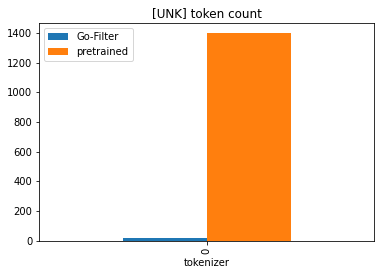

In [ ]:
pd.DataFrame({'Go-Filter':[unk_count_1], 'pretrained':[unk_count_2]}).plot.bar(title='[UNK] token count', xlabel='tokenizer', xlim=False)

In [ ]:
tokenized_texts_train = [tokenizer1.tokenize(sent) for sent in train_sentences]
tokenized_texts_val = [tokenizer1.tokenize(sent) for sent in validation_sentences]
tokenized_texts_test = [tokenizer1.tokenize(sent) for sent in test_sentences]

In [ ]:
max_len = 0
for txt in tokenized_texts_train:
  if len(txt) > max_len:
    max_len = len(txt)
print(f'train max_len = {max_len}')

train max_len = 77


In [ ]:
max_len = 0
for txt in tokenized_texts_val:
  if len(txt) > max_len:
    max_len = len(txt)
print(f'valid max_len = {max_len}')

valid max_len = 100


In [ ]:
max_len = 0
for txt in tokenized_texts_test:
  if len(txt) > max_len:
    max_len = len(txt)
print(f'test max_len = {max_len}')

test max_len = 82


In [ ]:
MAX_LEN = 100

def data_to_tensor (sentences, labels):
  tokenized_texts = [tokenizer1.tokenize(sent) for sent in sentences]
  input_ids = [tokenizer1.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post") 

  attention_masks = []

  for seq in input_ids:
      seq_mask = [float(i > 0) for i in seq]
      attention_masks.append(seq_mask)

  tensor_inputs = torch.tensor(input_ids)
  tensor_labels = torch.tensor(labels)
  tensor_masks = torch.tensor(attention_masks)

  return tensor_inputs, tensor_labels, tensor_masks

In [ ]:
train_inputs, train_labels, train_masks = data_to_tensor(train_sentences, train_labels)
validation_inputs, validation_labels, validation_masks = data_to_tensor(validation_sentences, validation_labels)
test_inputs, test_labels, test_masks = data_to_tensor(test_sentences, test_labels)

In [ ]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
print('testset size:', len(test_labels))
print('trainset size:', len(train_labels))
print('validset size:', len(validation_labels))

testset size: 122511
trainset size: 171514
validset size: 114344


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
num_labels = 8

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=num_labels, problem_type="multi_label_classification")
model.cuda()
model.load_state_dict(torch.load('/content/drive/Shareddrives/SW2_0916/3ck/model/BERT_model_epoch_4.pt'))

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

<All keys matched successfully>

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

# change epochs for improving results (our paper : epochs = 4)
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))  # hh:mm:ss

In [ ]:
def multi_label_metrics(predictions, labels, threshold=0.5):
    
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))

    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1

    # finally, compute metrics
    y_true = labels
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=0)
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0)
    f1_weighted_average = f1_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    hamming = hamming_loss(y_true, y_pred)

    # return as dictionary
    metrics = {'accuracy': accuracy,
               'f1_macro': f1_macro_average,
               'f1_micro': f1_micro_average,
               'f1_weighted': f1_weighted_average,
               'roc_auc': roc_auc,
               'hamming_loss': hamming}

    return metrics

In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.zero_grad()
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0

    model.train()

    for step, batch in tqdm(enumerate(train_dataloader)):
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # gradient clipping if it is over a threshold
        optimizer.step()
        scheduler.step()

        model.zero_grad()

    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    
print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...


0it [00:00, ?it/s]

  Batch   500  of  5,360.    Elapsed: 0:04:28.
  Batch 1,000  of  5,360.    Elapsed: 0:08:53.
  Batch 1,500  of  5,360.    Elapsed: 0:13:18.
  Batch 2,000  of  5,360.    Elapsed: 0:17:43.
  Batch 2,500  of  5,360.    Elapsed: 0:22:09.
  Batch 3,000  of  5,360.    Elapsed: 0:26:34.
  Batch 3,500  of  5,360.    Elapsed: 0:30:59.
  Batch 4,000  of  5,360.    Elapsed: 0:35:24.
  Batch 4,500  of  5,360.    Elapsed: 0:39:50.
  Batch 5,000  of  5,360.    Elapsed: 0:44:15.

  Average training loss: 0.1870
  Training epcoh took: 0:47:26

======== Epoch 2 / 10 ========
Training...


0it [00:00, ?it/s]

  Batch   500  of  5,360.    Elapsed: 0:04:25.
  Batch 1,000  of  5,360.    Elapsed: 0:08:51.
  Batch 1,500  of  5,360.    Elapsed: 0:13:16.
  Batch 2,000  of  5,360.    Elapsed: 0:17:42.
  Batch 2,500  of  5,360.    Elapsed: 0:22:07.
  Batch 3,000  of  5,360.    Elapsed: 0:26:32.
  Batch 3,500  of  5,360.    Elapsed: 0:30:58.
  Batch 4,000  of  5,360.    Elapsed: 0:35:23.
  Batch 4,500  of  5,360.    Elapsed: 0:39:48.
  Batch 5,000  of  5,360.    Elapsed: 0:44:14.

  Average training loss: 0.1513
  Training epcoh took: 0:47:24

======== Epoch 3 / 10 ========
Training...


0it [00:00, ?it/s]

  Batch   500  of  5,360.    Elapsed: 0:04:25.
  Batch 1,000  of  5,360.    Elapsed: 0:08:51.
  Batch 1,500  of  5,360.    Elapsed: 0:13:16.
  Batch 2,000  of  5,360.    Elapsed: 0:17:42.
  Batch 2,500  of  5,360.    Elapsed: 0:22:07.
  Batch 3,000  of  5,360.    Elapsed: 0:26:32.
  Batch 3,500  of  5,360.    Elapsed: 0:30:58.
  Batch 4,000  of  5,360.    Elapsed: 0:35:23.
  Batch 4,500  of  5,360.    Elapsed: 0:39:48.
  Batch 5,000  of  5,360.    Elapsed: 0:44:13.

  Average training loss: 0.1364
  Training epcoh took: 0:47:24

======== Epoch 4 / 10 ========
Training...


0it [00:00, ?it/s]

  Batch   500  of  5,360.    Elapsed: 0:04:25.
  Batch 1,000  of  5,360.    Elapsed: 0:08:51.
  Batch 1,500  of  5,360.    Elapsed: 0:13:16.
  Batch 2,000  of  5,360.    Elapsed: 0:17:41.
  Batch 2,500  of  5,360.    Elapsed: 0:22:06.
  Batch 3,000  of  5,360.    Elapsed: 0:26:31.
  Batch 3,500  of  5,360.    Elapsed: 0:30:57.
  Batch 4,000  of  5,360.    Elapsed: 0:35:22.
  Batch 4,500  of  5,360.    Elapsed: 0:39:48.
  Batch 5,000  of  5,360.    Elapsed: 0:44:13.

  Average training loss: 0.1356
  Training epcoh took: 0:47:24

======== Epoch 5 / 10 ========
Training...


0it [00:00, ?it/s]

  Batch   500  of  5,360.    Elapsed: 0:04:25.
  Batch 1,000  of  5,360.    Elapsed: 0:08:51.
  Batch 1,500  of  5,360.    Elapsed: 0:13:16.
  Batch 2,000  of  5,360.    Elapsed: 0:17:42.
  Batch 2,500  of  5,360.    Elapsed: 0:22:07.
  Batch 3,000  of  5,360.    Elapsed: 0:26:33.
  Batch 3,500  of  5,360.    Elapsed: 0:30:58.
  Batch 4,000  of  5,360.    Elapsed: 0:35:23.
  Batch 4,500  of  5,360.    Elapsed: 0:39:48.
  Batch 5,000  of  5,360.    Elapsed: 0:44:13.

  Average training loss: 0.1264
  Training epcoh took: 0:47:24

======== Epoch 6 / 10 ========
Training...


0it [00:00, ?it/s]

  Batch   500  of  5,360.    Elapsed: 0:04:25.
  Batch 1,000  of  5,360.    Elapsed: 0:08:50.
  Batch 1,500  of  5,360.    Elapsed: 0:13:16.
  Batch 2,000  of  5,360.    Elapsed: 0:17:41.
  Batch 2,500  of  5,360.    Elapsed: 0:22:07.
  Batch 3,000  of  5,360.    Elapsed: 0:26:32.
  Batch 3,500  of  5,360.    Elapsed: 0:30:57.
  Batch 4,000  of  5,360.    Elapsed: 0:35:22.
  Batch 4,500  of  5,360.    Elapsed: 0:39:48.
  Batch 5,000  of  5,360.    Elapsed: 0:44:12.

  Average training loss: 0.1081
  Training epcoh took: 0:47:23

======== Epoch 7 / 10 ========
Training...


0it [00:00, ?it/s]

  Batch   500  of  5,360.    Elapsed: 0:04:25.
  Batch 1,000  of  5,360.    Elapsed: 0:08:50.
  Batch 1,500  of  5,360.    Elapsed: 0:13:15.
  Batch 2,000  of  5,360.    Elapsed: 0:17:40.
  Batch 2,500  of  5,360.    Elapsed: 0:22:05.
  Batch 3,000  of  5,360.    Elapsed: 0:26:31.
  Batch 3,500  of  5,360.    Elapsed: 0:30:56.
  Batch 4,000  of  5,360.    Elapsed: 0:35:21.
  Batch 4,500  of  5,360.    Elapsed: 0:39:46.
  Batch 5,000  of  5,360.    Elapsed: 0:44:12.

  Average training loss: 0.0933
  Training epcoh took: 0:47:22

======== Epoch 8 / 10 ========
Training...


0it [00:00, ?it/s]

  Batch   500  of  5,360.    Elapsed: 0:04:25.
  Batch 1,000  of  5,360.    Elapsed: 0:08:50.
  Batch 1,500  of  5,360.    Elapsed: 0:13:15.
  Batch 2,000  of  5,360.    Elapsed: 0:17:41.
  Batch 2,500  of  5,360.    Elapsed: 0:22:06.
  Batch 3,000  of  5,360.    Elapsed: 0:26:31.
  Batch 3,500  of  5,360.    Elapsed: 0:30:56.
  Batch 4,000  of  5,360.    Elapsed: 0:35:21.
  Batch 4,500  of  5,360.    Elapsed: 0:39:46.
  Batch 5,000  of  5,360.    Elapsed: 0:44:11.

  Average training loss: 0.0811
  Training epcoh took: 0:47:22

======== Epoch 9 / 10 ========
Training...


0it [00:00, ?it/s]

  Batch   500  of  5,360.    Elapsed: 0:04:25.
  Batch 1,000  of  5,360.    Elapsed: 0:08:50.
  Batch 1,500  of  5,360.    Elapsed: 0:13:15.
  Batch 2,000  of  5,360.    Elapsed: 0:17:40.
  Batch 2,500  of  5,360.    Elapsed: 0:22:05.
  Batch 3,000  of  5,360.    Elapsed: 0:26:30.
  Batch 3,500  of  5,360.    Elapsed: 0:30:55.
  Batch 4,000  of  5,360.    Elapsed: 0:35:20.
  Batch 4,500  of  5,360.    Elapsed: 0:39:45.
  Batch 5,000  of  5,360.    Elapsed: 0:44:10.

  Average training loss: 0.0718
  Training epcoh took: 0:47:21

======== Epoch 10 / 10 ========
Training...


0it [00:00, ?it/s]

  Batch   500  of  5,360.    Elapsed: 0:04:25.
  Batch 1,000  of  5,360.    Elapsed: 0:08:50.
  Batch 1,500  of  5,360.    Elapsed: 0:13:15.
  Batch 2,000  of  5,360.    Elapsed: 0:17:40.
  Batch 2,500  of  5,360.    Elapsed: 0:22:06.
  Batch 3,000  of  5,360.    Elapsed: 0:26:31.
  Batch 3,500  of  5,360.    Elapsed: 0:30:56.
  Batch 4,000  of  5,360.    Elapsed: 0:35:21.
  Batch 4,500  of  5,360.    Elapsed: 0:39:46.
  Batch 5,000  of  5,360.    Elapsed: 0:44:11.

  Average training loss: 0.0650
  Training epcoh took: 0:47:21

Training complete!


In [ ]:
# ========================================
#               Validation
# ========================================

print("")
print("Running Validation...")

t0 = time.time()
model.eval()
accum_logits, accum_label_ids = [], []

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    for b in logits:
        accum_logits.append(list(b))

    for b in label_ids:
        accum_label_ids.append(list(b))

accum_logits = np.array(accum_logits)
accum_label_ids = np.array(accum_label_ids)
results = multi_label_metrics(accum_logits, accum_label_ids)

print("Accuracy: {0:.4f}".format(results['accuracy']))
print("F1 (Macro) Score: {0:.4f}".format(results['f1_macro']))
print("F1 (Micro) Score: {0:.4f}".format(results['f1_micro']))
print("F1 (Weighted) Score: {0:.4f}".format(results['f1_weighted']))
print("ROC-AUC: {0:.4f}".format(results['roc_auc']))
print("Hamming Loss: {0:.4f}".format(results['hamming_loss']))
print("Validation took: {:}".format(format_time(time.time() - t0)))


Running Validation...
Accuracy: 0.5088
F1 (Macro) Score: 0.4684
F1 (Micro) Score: 0.6357
F1 (Weighted) Score: 0.6291
ROC-AUC: 0.7787
Hamming Loss: 0.1157
Validation took: 0:10:34


In [ ]:
# model save

path = '/content/drive/Shareddrives/SW2_0916/3ck/model/'
torch.save(model.state_dict(), path+"BERT_model_epoch_10.pt")

In [ ]:
# load the saved model
model.load_state_dict(torch.load(path+"BERT_model_epoch_10.pt"))

<All keys matched successfully>

In [ ]:
t0 = time.time()
model.eval()
accum_logits, accum_label_ids = [], []

for step, batch in tqdm(enumerate(test_dataloader)):
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    for b in logits:
        accum_logits.append(list(b))

    for b in label_ids:
        accum_label_ids.append(list(b))

accum_logits = np.array(accum_logits)
accum_label_ids = np.array(accum_label_ids)
results = multi_label_metrics(accum_logits, accum_label_ids)

print("")
print("Accuracy: {0:.4f}".format(results['accuracy']))
print("F1 (Macro) Score: {0:.4f}".format(results['f1_macro']))
print("F1 (Micro) Score: {0:.4f}".format(results['f1_micro']))
print("F1 (Weighted) Score: {0:.4f}".format(results['f1_weighted']))
print("ROC-AUC: {0:.4f}".format(results['roc_auc']))
print("Hamming Loss: {0:.4f}".format(results['hamming_loss']))
print("Test took: {:}".format(format_time(time.time() - t0)))

accum_results = []
accum_results.append(list(results.values()))

0it [00:00, ?it/s]

  Batch   100  of  3,829.    Elapsed: 0:00:18.
  Batch   200  of  3,829.    Elapsed: 0:00:36.
  Batch   300  of  3,829.    Elapsed: 0:00:53.
  Batch   400  of  3,829.    Elapsed: 0:01:11.
  Batch   500  of  3,829.    Elapsed: 0:01:29.
  Batch   600  of  3,829.    Elapsed: 0:01:46.
  Batch   700  of  3,829.    Elapsed: 0:02:04.
  Batch   800  of  3,829.    Elapsed: 0:02:22.
  Batch   900  of  3,829.    Elapsed: 0:02:40.
  Batch 1,000  of  3,829.    Elapsed: 0:02:58.
  Batch 1,100  of  3,829.    Elapsed: 0:03:15.
  Batch 1,200  of  3,829.    Elapsed: 0:03:33.
  Batch 1,300  of  3,829.    Elapsed: 0:03:51.
  Batch 1,400  of  3,829.    Elapsed: 0:04:08.
  Batch 1,500  of  3,829.    Elapsed: 0:04:26.
  Batch 1,600  of  3,829.    Elapsed: 0:04:45.
  Batch 1,700  of  3,829.    Elapsed: 0:05:02.
  Batch 1,800  of  3,829.    Elapsed: 0:05:20.
  Batch 1,900  of  3,829.    Elapsed: 0:05:38.
  Batch 2,000  of  3,829.    Elapsed: 0:05:56.
  Batch 2,100  of  3,829.    Elapsed: 0:06:13.
  Batch 2,200

In [ ]:
for i in range(num_labels):
    ith_label_ids, ith_logits = [], []
    
    for j, labels in enumerate(accum_label_ids):
        if len(np.where(labels)[0]) == i+1:
            ith_label_ids.append(accum_label_ids[j].tolist())
            ith_logits.append(accum_logits[j].tolist())

    ith_label_ids = np.array(ith_label_ids)
    ith_logits = np.array(ith_logits)

    if len(ith_label_ids) == 0 and len(ith_logits) == 0:
        continue

    results = multi_label_metrics(ith_logits, ith_label_ids)
    accum_results.append(list(results.values()))
    
    print('# of labels:', i+1)
    print("Accuracy: {0:.4f}".format(results['accuracy']))
    print("F1 (Macro) Score: {0:.4f}".format(results['f1_macro']))
    print("F1 (Micro) Score: {0:.4f}".format(results['f1_micro']))
    print("F1 (Weighted) Score: {0:.4f}".format(results['f1_weighted']))
    print("ROC-AUC: {0:.4f}".format(results['roc_auc']))
    print("Hamming Loss: {0:.4f}".format(results['hamming_loss']))

    print('\n')

# of labels: 1
Accuracy: 0.6174
F1 (Macro) Score: 0.3605
F1 (Micro) Score: 0.6613
F1 (Weighted) Score: 0.6931
ROC-AUC: 0.8229
Hamming Loss: 0.0906


# of labels: 2
Accuracy: 0.1609
F1 (Macro) Score: 0.4237
F1 (Micro) Score: 0.5895
F1 (Weighted) Score: 0.5994
ROC-AUC: 0.7196
Hamming Loss: 0.1820


# of labels: 3
Accuracy: 0.0969
F1 (Macro) Score: 0.4450
F1 (Micro) Score: 0.6034
F1 (Weighted) Score: 0.5994
ROC-AUC: 0.7071
Hamming Loss: 0.2356


# of labels: 4
Accuracy: 0.0439
F1 (Macro) Score: 0.4480
F1 (Micro) Score: 0.5868
F1 (Weighted) Score: 0.5729
ROC-AUC: 0.6897
Hamming Loss: 0.3103


# of labels: 5
Accuracy: 0.0109
F1 (Macro) Score: 0.4508
F1 (Micro) Score: 0.5471
F1 (Weighted) Score: 0.5287
ROC-AUC: 0.6630
Hamming Loss: 0.4049


# of labels: 6
Accuracy: 0.0000
F1 (Macro) Score: 0.3417
F1 (Micro) Score: 0.4390
F1 (Weighted) Score: 0.3978
ROC-AUC: 0.5500
Hamming Loss: 0.5750


